Notebook created to measure the time needed to predict the mass percentiles, metallicity and [alpha/fe] of a galaxy given its spectrum

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference


In [3]:
index_sh=np.load('./saved_models/ind_sh.npy')
seds=np.load('../../seds_large/norm/seds.npy') 
y=np.load('./saved_input/y.npy',allow_pickle=True)
wave=np.load('./saved_input/wave.npy')

seds=seds[index_sh[:1000],:]
y=y[index_sh[:1000],:]

In [116]:
"""#reshape y

batch_size=512 

y=np.zeros((27000,10))

#to create a single dataset with all the minibatches
for j in range(len(y_b)):
    for i,x in enumerate(y_b[j]):
        y[batch_size*j+i,:]=x"""
        

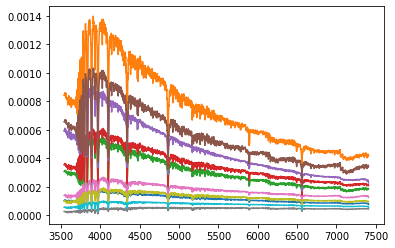

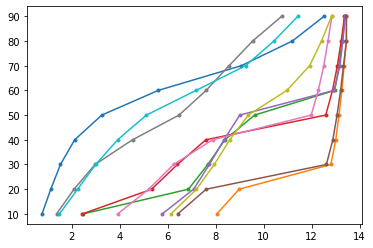

In [5]:

for i in range(10):
    plt.plot(wave, seds[i,:],c='C'+str(i))
plt.show()

for i in range(10):
    plt.plot(y[i,:9],np.arange(10,100,10),'.-',c='C'+str(i))
plt.show()



In [4]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        self.y=torch.from_numpy(y) #percentiles


    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        y=self.y[index,:]
        return x,y


In [7]:
#create a pytorch dataset

dataset = Dataset(seds[:1000,:], y[:1000,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=10)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

  0%|                                                                                                                                                  | 0/1000 [00:00<?, ?it/s]

Getting latent vectors and predicted percentiles


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.51it/s]


In [8]:
file="./saved_models/my_posterior.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

In [ ]:
posteriors=[]


for i in trange(1000): 
    posteriors.append(np.array(qphi.sample((1,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)[:,0,:]

(1000, 11)


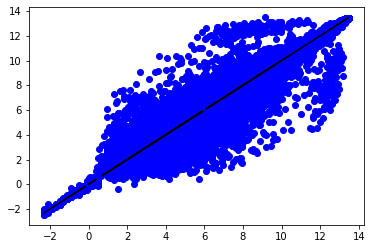

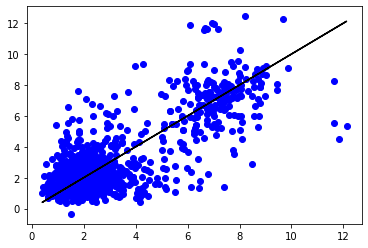

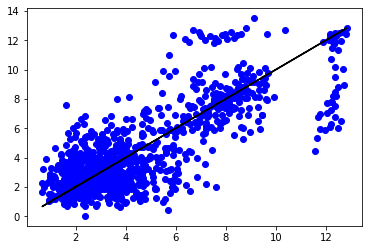

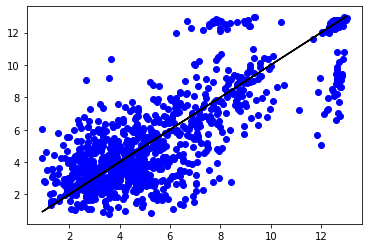

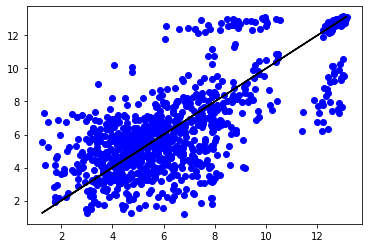

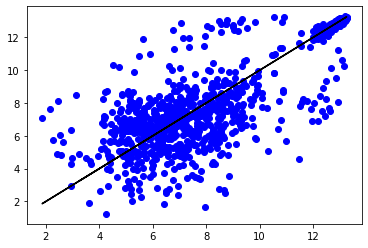

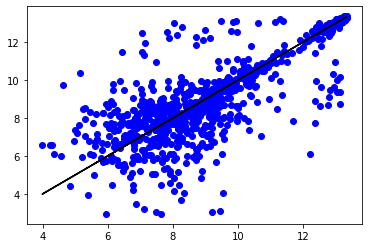

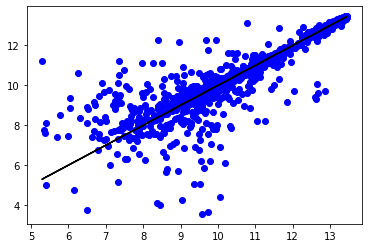

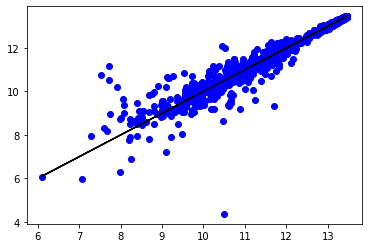

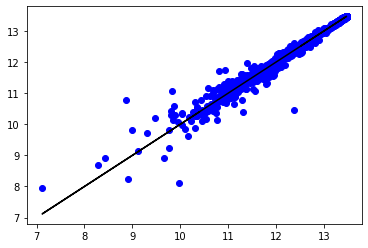

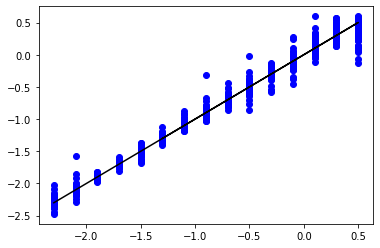

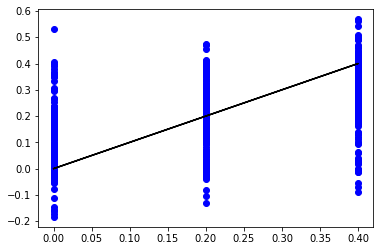

In [10]:
print(np.shape(posteriors))

for i in range(11):
    plt.plot(y[:1000,i],posteriors[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
plt.show()

for i in range(11):
    plt.plot(y[:1000,i],posteriors[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
    plt.show()

So, time needed to generate the latent vector:
    
32/1000=0.032 s

Time to generate a single sample (not a distribution):

19/1000= 0.019 s

In total, for a single prediction of the 9 percentiles + metallicity:

0.032 + 0.019 = 0.051 s


Right now we try to predict distributions (1000 samples)

In [10]:
posteriors_dist=[]


for i in trange(10): #10.000 or 1.000
    posteriors_dist.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors_dist=np.array(posteriors_dist)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.95s/it]


Time for 1000 predictions for each galaxy:

(5*60+58) /1000 = 0.358 s

In total:

0.032+0.358= 0.39 s

(1000, 1000, 11)
(1000, 11)


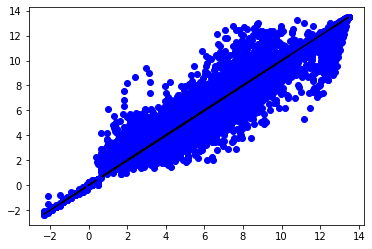

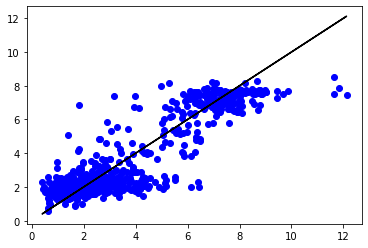

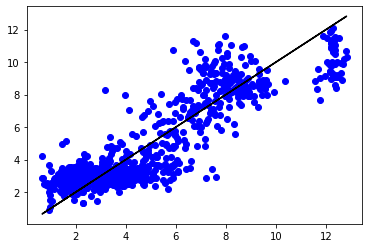

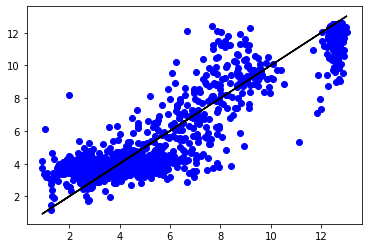

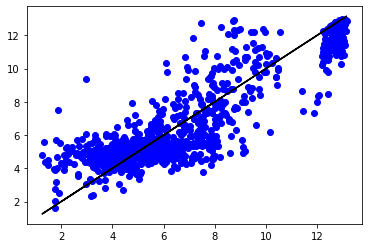

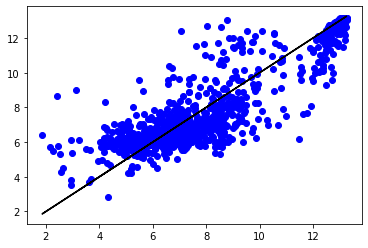

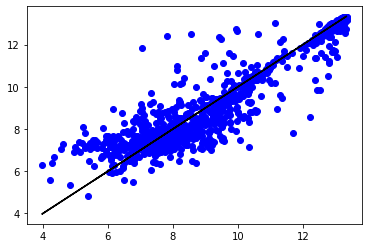

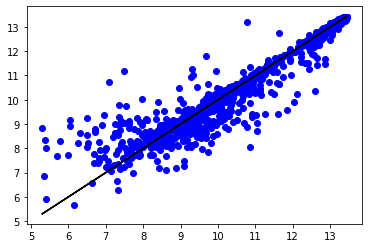

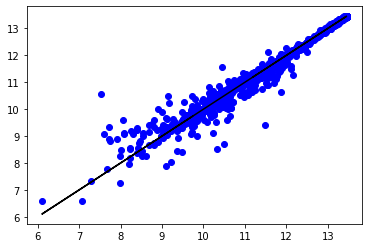

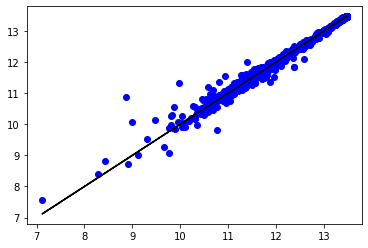

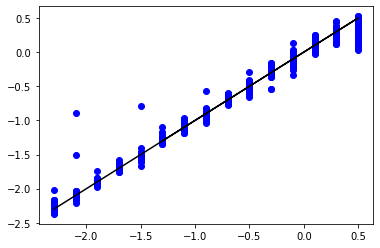

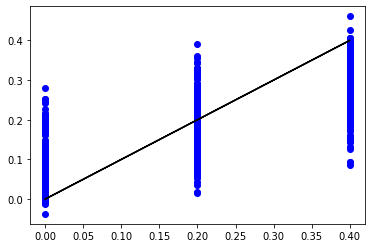

In [12]:
print(np.shape(posteriors_dist))

means=np.mean(posteriors_dist,axis=1)

print(np.shape(means))


for i in range(11):
    plt.plot(y[:1000,i],means[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
plt.show()


for i in range(11):
    plt.plot(y[:1000,i],means[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
    plt.show()
    

  0%|                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

Getting latent vectors and predicted percentiles


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.80s/it]


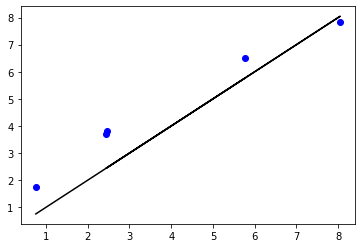

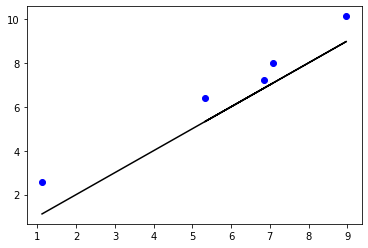

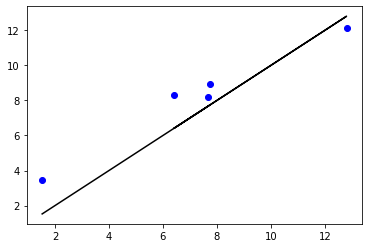

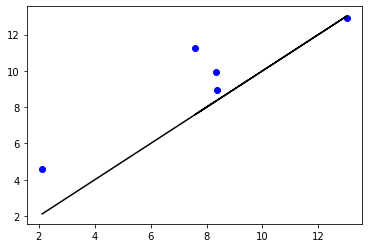

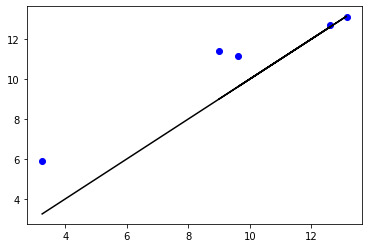

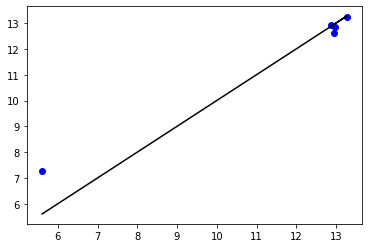

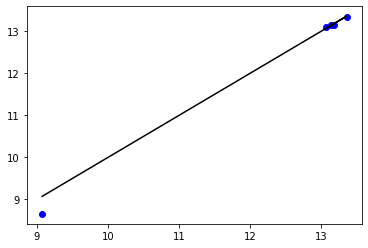

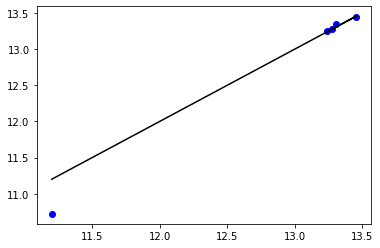

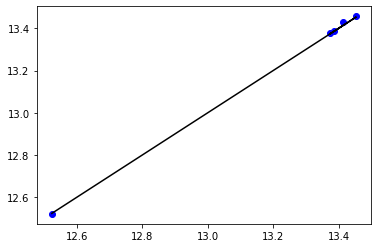

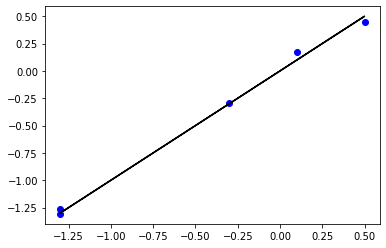

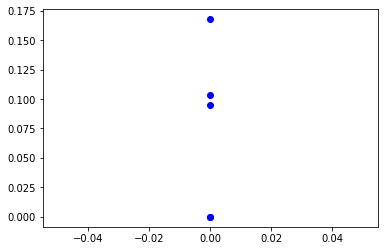

[[ 25.593073    12.887668    25.497885    28.944262    16.719963
  -21.187004   -50.706135    69.89342      8.707426   -62.064228
  -16.41632     80.072205   -31.080748   -63.8128     -51.898438
   27.963299  ]
 [ 30.309774    12.572905    25.483728    27.694513    -2.89322
  -22.904186   -41.383926    55.59591     -1.482271   -25.464754
  -15.88175     51.50832    -16.01879    -38.694057   -35.870964
   -0.39112735]
 [ 28.112165    12.820187    27.574238    29.348703    11.567904
  -20.383589   -47.134113    66.90256      7.0037417  -51.16621
  -16.515982    71.54918    -25.499393   -58.836296   -49.15528
   19.270933  ]
 [ 27.274553    12.707716    26.488146    28.561262    10.793094
  -20.663067   -46.69461     65.381775     6.152893   -50.37998
  -16.328442    70.475464   -25.89931    -56.63836    -47.59288
   19.022299  ]
 [ 29.129066    12.094772    25.210882    27.924906    -2.4936152
  -22.481085   -42.340504    55.8939      -0.72610456 -29.770908
  -16.576408    54.53672    -1

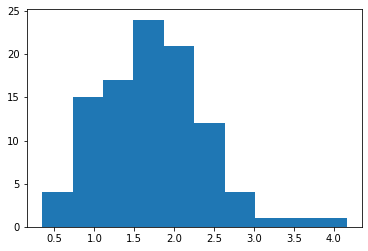

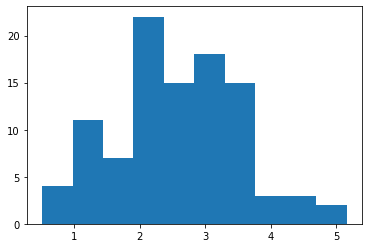

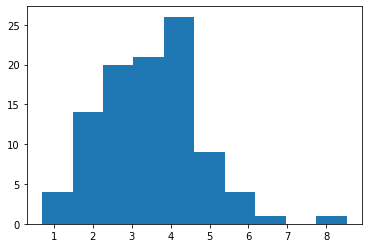

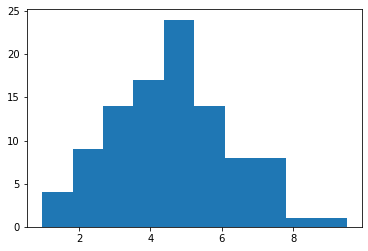

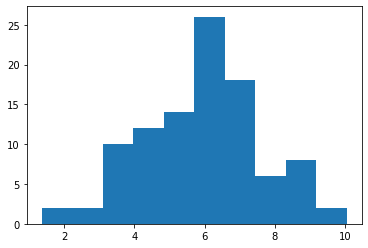

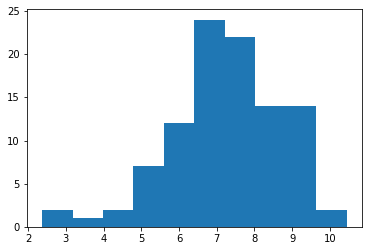

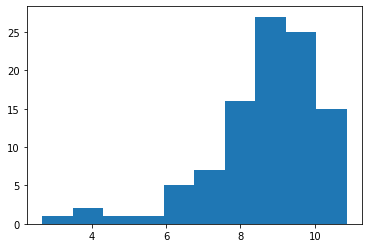

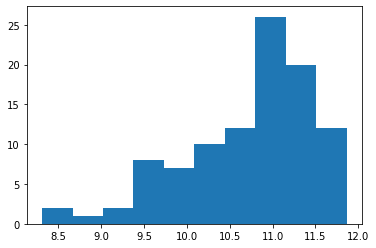

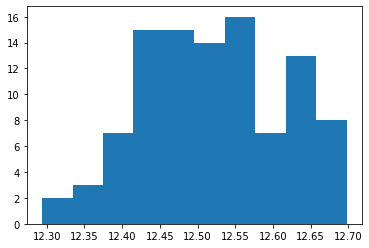

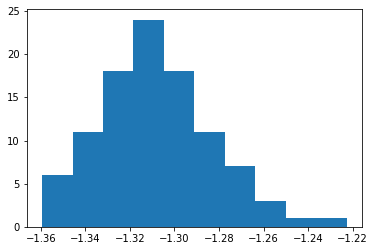

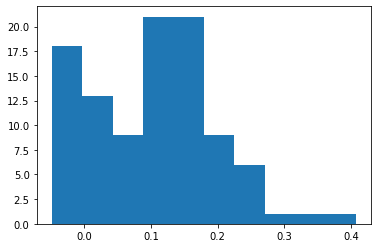

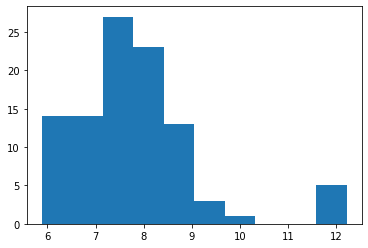

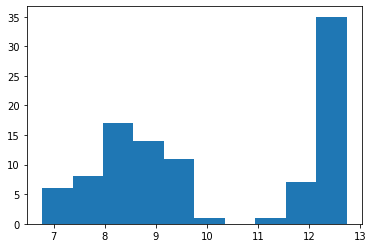

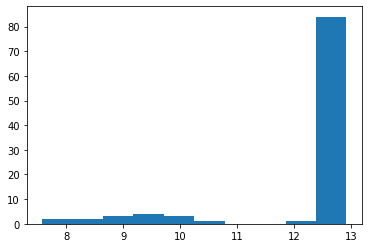

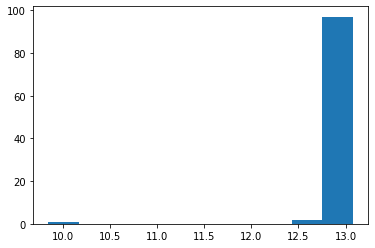

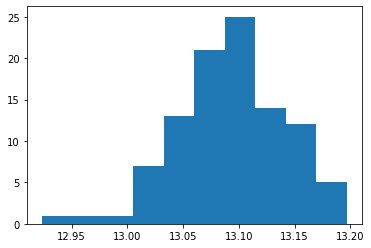

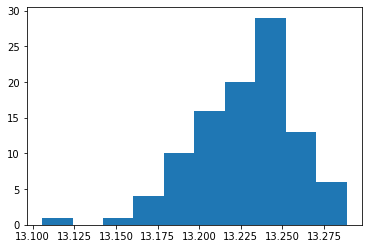

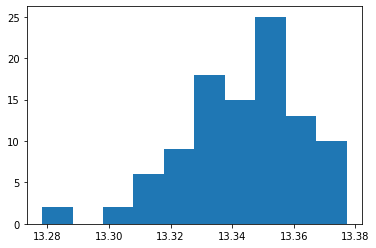

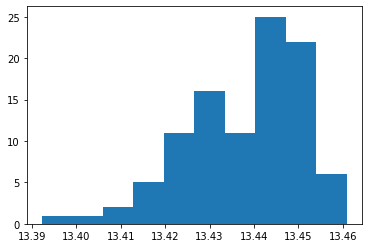

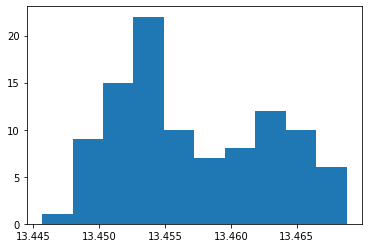

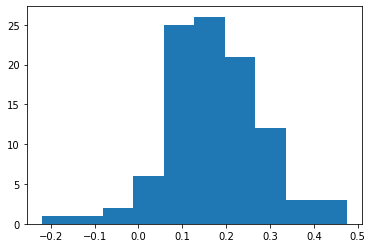

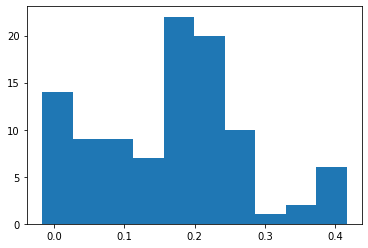

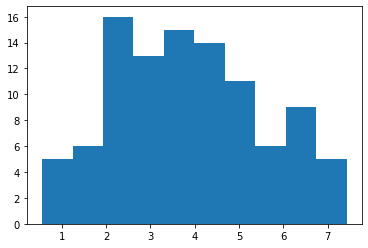

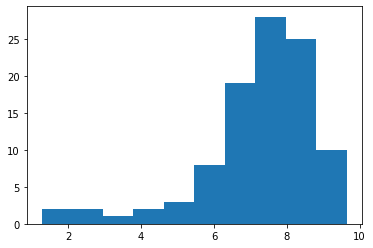

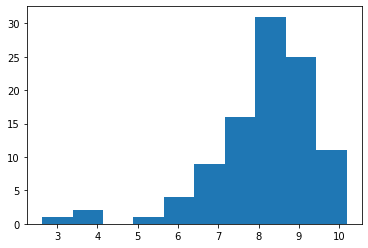

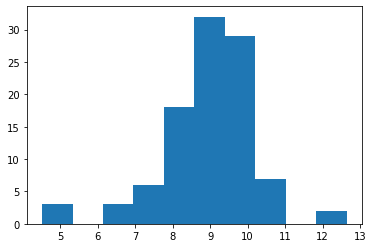

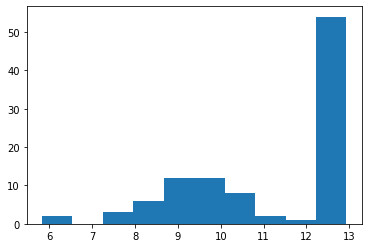

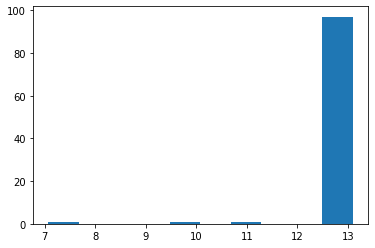

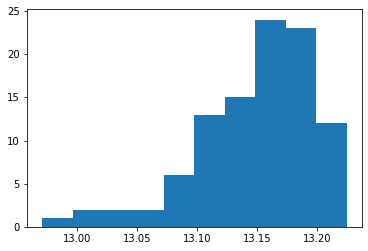

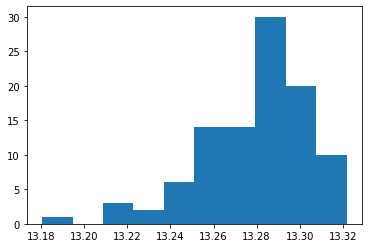

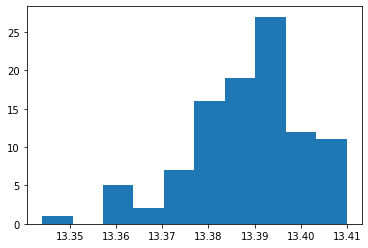

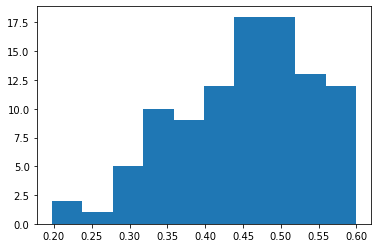

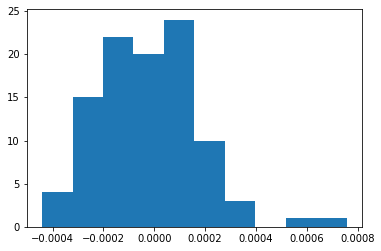

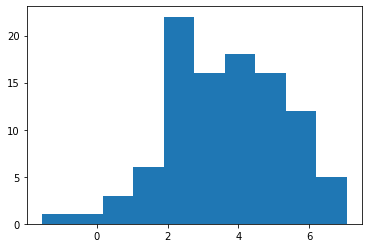

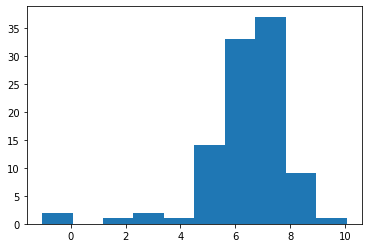

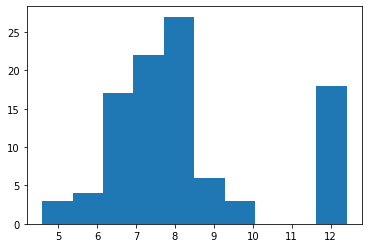

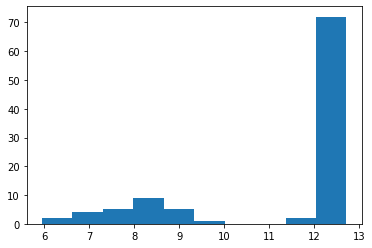

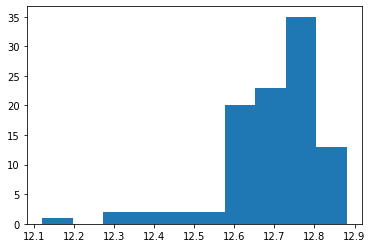

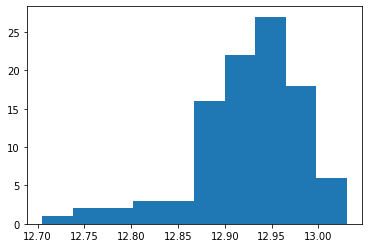

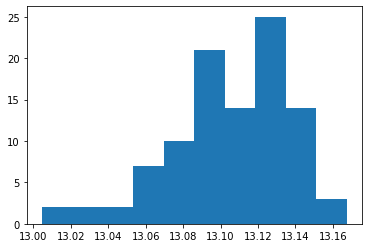

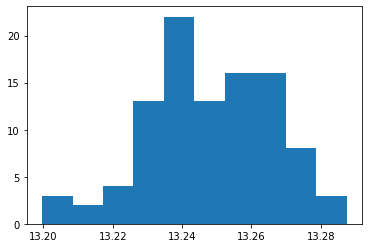

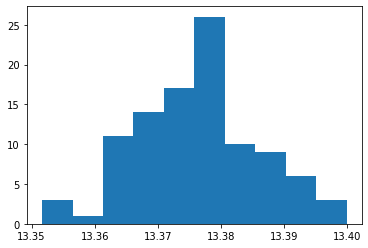

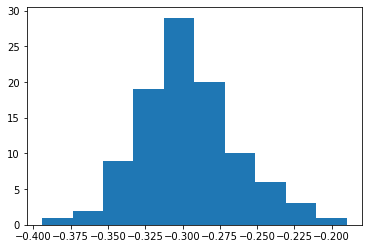

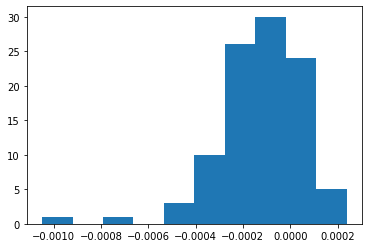

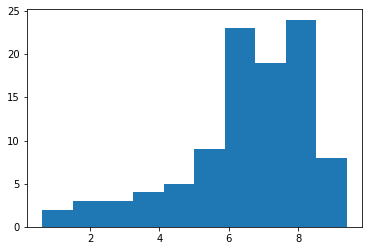

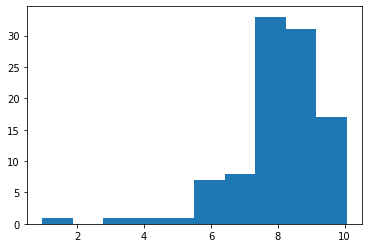

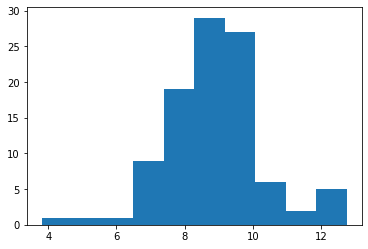

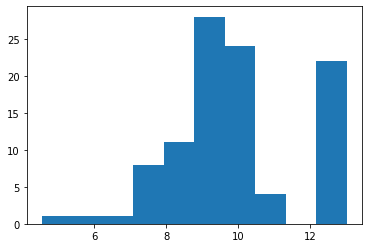

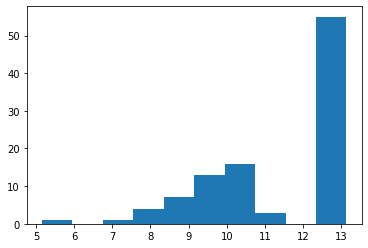

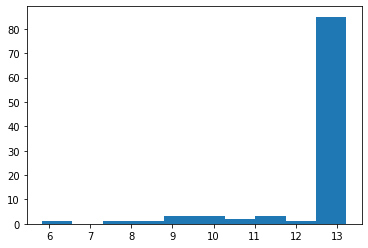

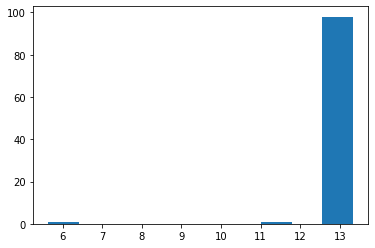

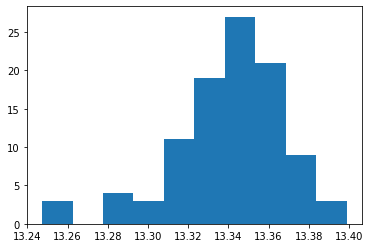

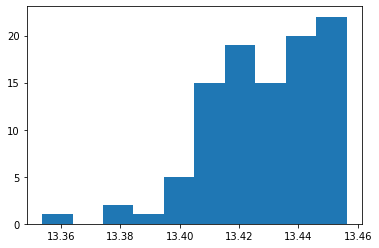

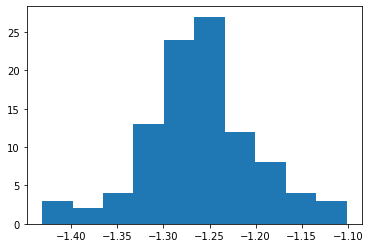

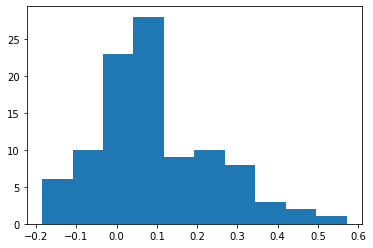

In [46]:


#imagine we limit ourselves to the first 5 spectra and we multiply their fluxes by 5


#create a pytorch dataset

dataset = Dataset(seds[:5,:], y[:5,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint_b.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=11)
model = accelerator.prepare(model)
        
#predict spender
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

#predict SNPE

posteriors_dist=[]


for i in trange(5):
    posteriors_dist.append(np.array(qphi.sample((100,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors_dist=np.array(posteriors_dist)


means=np.mean(posteriors_dist,axis=1)


for i in range(11):
    plt.plot(y[:5,i],means[:,i],'bo')
    plt.plot(y[:5,i],y[:5,i],'k-')
    plt.show()

print(ss)

ss_or=ss

print(means)

means_or=means


for j in range(1):
    for i in range(11):
        plt.hist(posteriors_dist[j,:,i])
        plt.show()

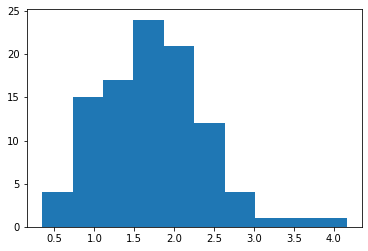

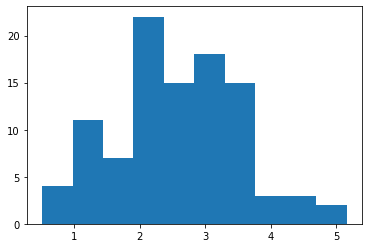

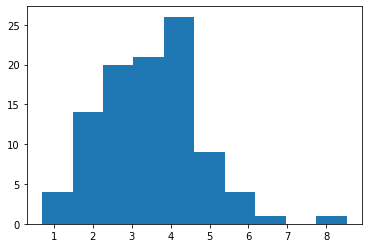

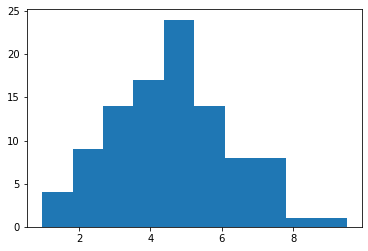

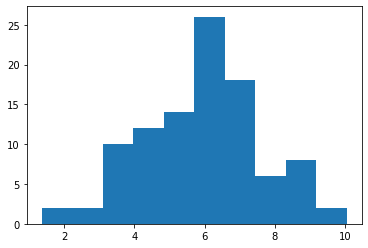

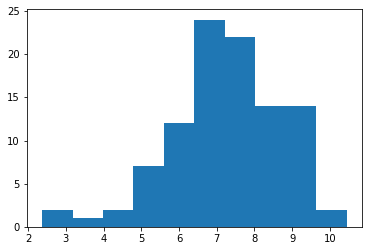

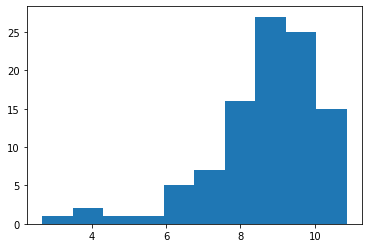

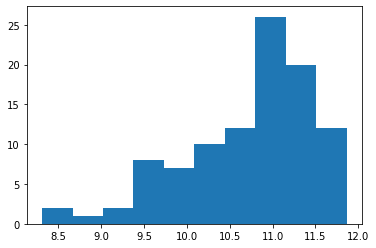

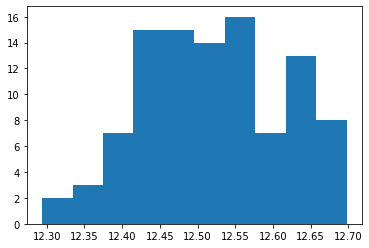

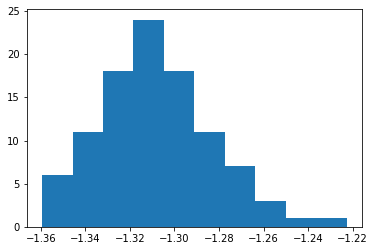

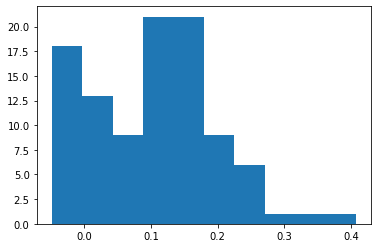

In [48]:
for j in range(1):
    for i in range(11):
        plt.hist(posteriors_dist[j,:,i])
        plt.show()
        
posteriors_dist_or=posteriors_dist

In [44]:
print(np.shape(posteriors_dist))

(5, 1000, 11)


In [ ]:


# we multiply their fluxes by 5


#create a pytorch dataset

dataset = Dataset(5*seds[:5,:], y[:5,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint_b.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=11)
model = accelerator.prepare(model)
        
#predict spender
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

print(ss)

ss5=ss

#predict SNPE

posteriors_dist=[]


for i in trange(5):
    posteriors_dist.append(np.array(qphi.sample((1,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))  
posteriors_dist=np.array(posteriors_dist)


means=np.mean(posteriors_dist,axis=1)


for i in range(11):
    plt.plot(y[:5,i],means[:,i],'bo')
    plt.plot(y[:5,i],y[:5,i],'k-')
    plt.show()
    
"""WARNING:root:Only 0.027% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    997 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')"""


print(means)


ss5=ss
means5=means


        
posteriors_dist5=posteriors_dist
    
    

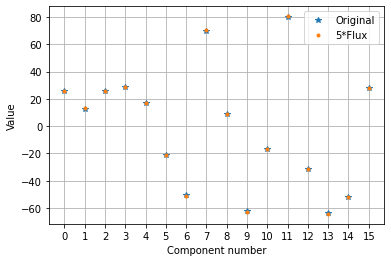

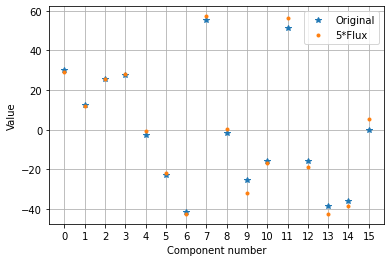

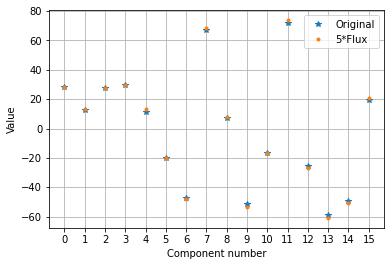

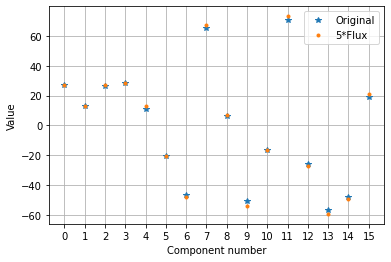

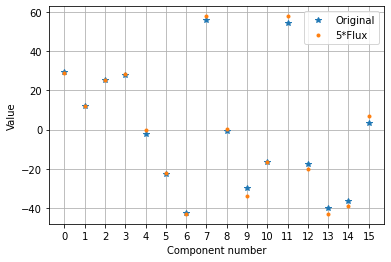

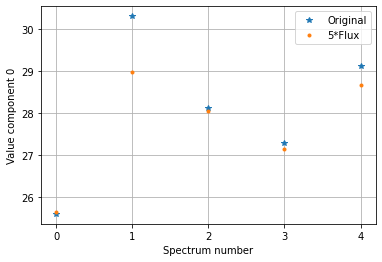

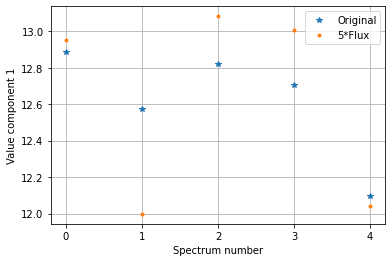

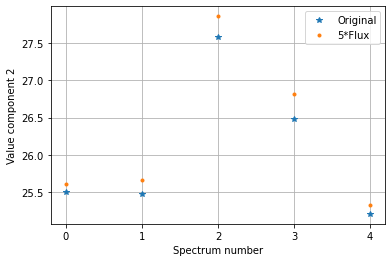

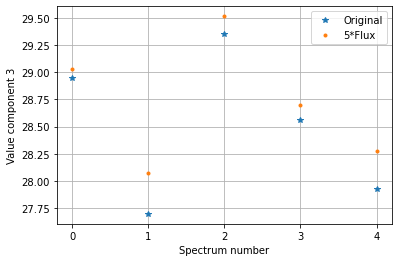

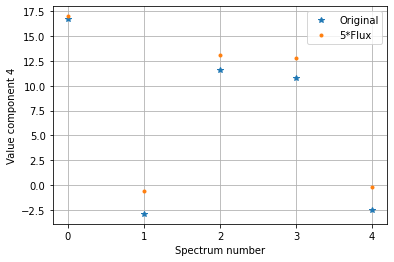

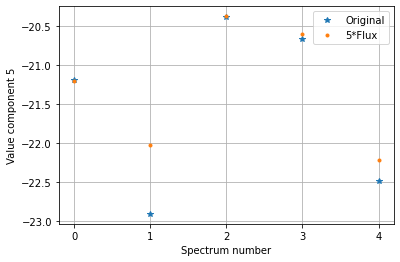

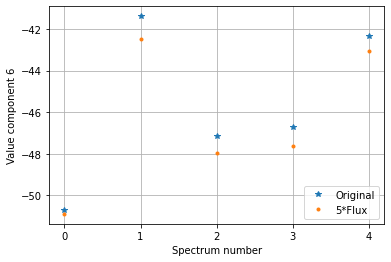

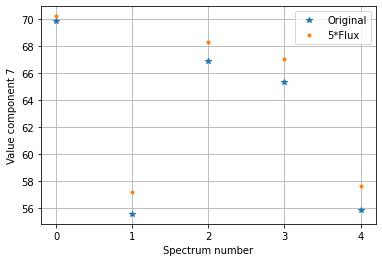

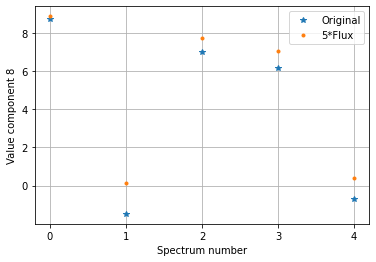

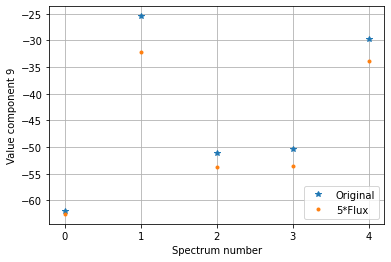

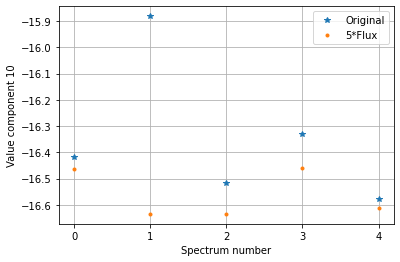

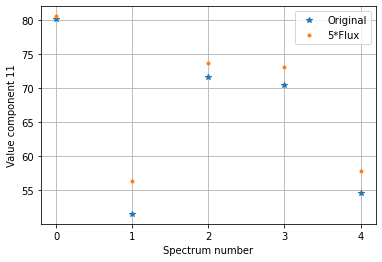

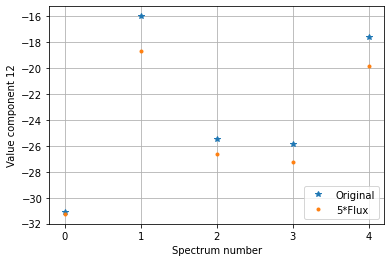

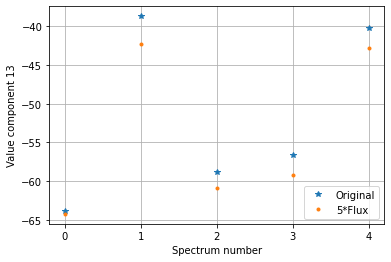

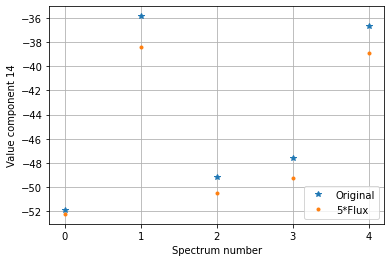

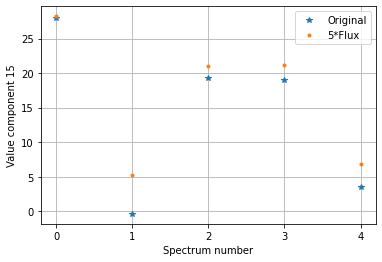

In [32]:
 for i in range(5):
    plt.plot(range(16),ss_or[i],'*',label='Original')
    plt.plot(range(16),ss5[i],'.',label='5*Flux')
    plt.xlabel('Component number')
    plt.ylabel('Value')
    plt.xticks(range(16))
    plt.legend()
    plt.grid()
    plt.show()
    
for j in range(16):
    plt.plot(range(5),ss_or[:,j],'*',label='Original')
    plt.plot(range(5),ss5[:,j],'.',label='5*Flux')
    plt.xlabel('Spectrum number')
    plt.xticks(range(5))
    plt.ylabel('Value component '+str(j))
    plt.legend()
    plt.grid()
    plt.show()
    
    

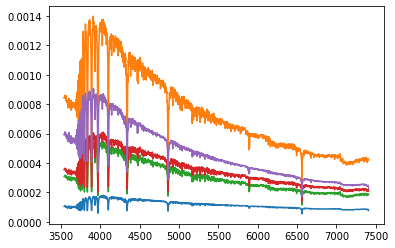

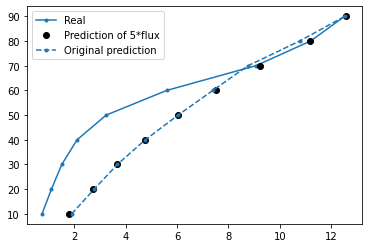

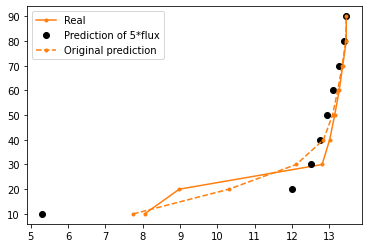

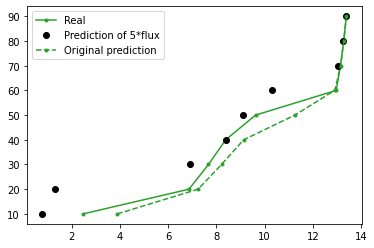

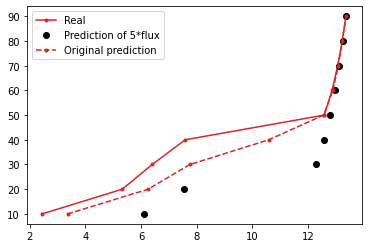

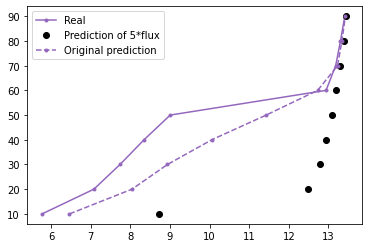

In [41]:
for i in range(5):
    plt.plot(wave, seds[i,:],c='C'+str(i))
plt.show()

for i in range(5):
    plt.plot(y[i,:9],np.arange(10,100,10),'.-',c='C'+str(i),label='Real') #true
    plt.plot(means5[i,:9],np.arange(10,100,10),'o',c='k',label='Prediction of 5*flux') #flux by 5 
    plt.plot(means_or[i,:9],np.arange(10,100,10),'.--',c='C'+str(i),label='Original prediction') #original
    plt.legend()
    plt.show()


#doesnt work reall well

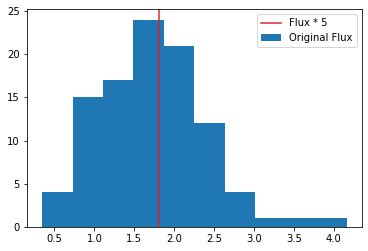

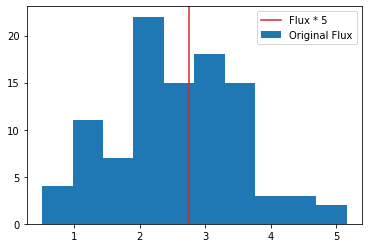

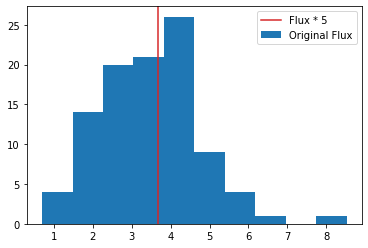

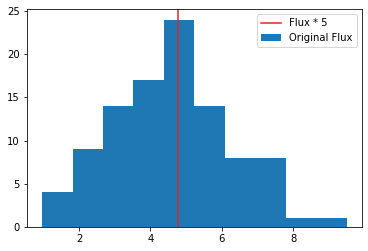

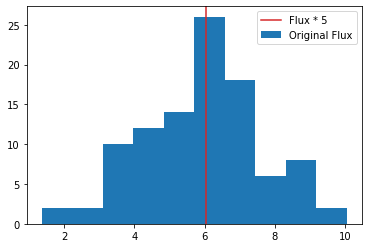

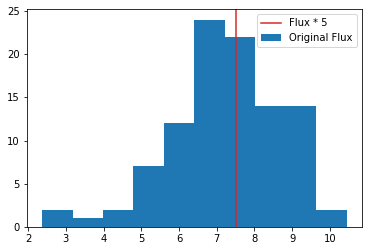

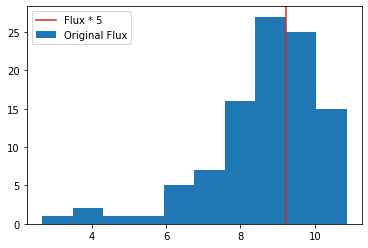

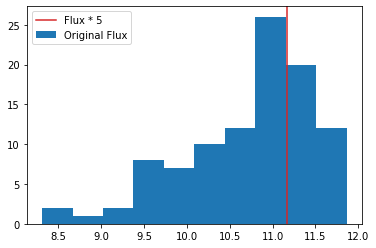

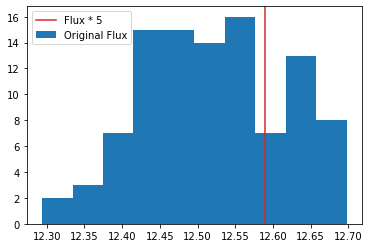

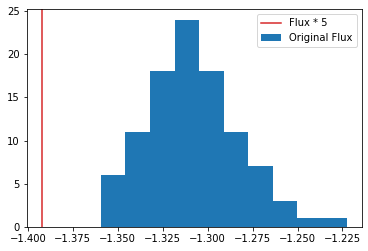

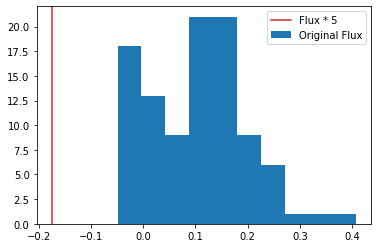

In [54]:
j=0
for i in range(11):
        plt.hist(posteriors_dist_or[j,:,i],color='tab:blue',label='Original Flux')
        plt.axvline(means5[j,i],0,1,color='tab:red',label='Flux * 5')
        plt.legend()
        plt.show()

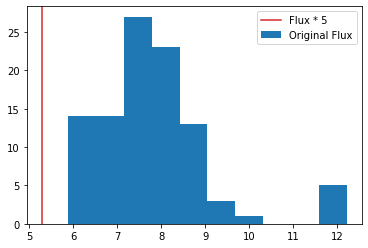

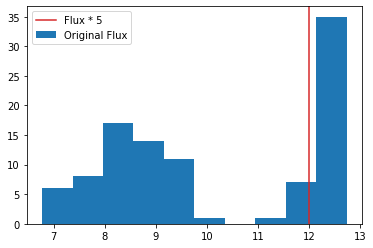

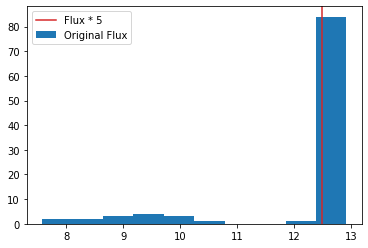

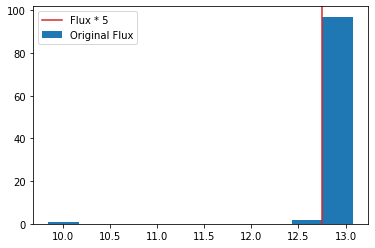

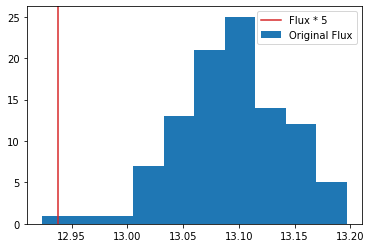

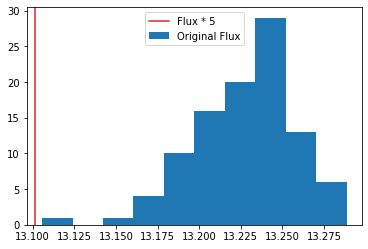

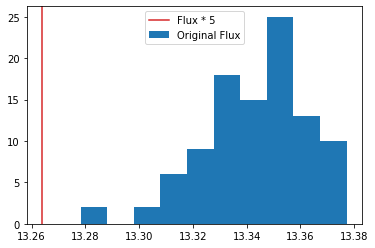

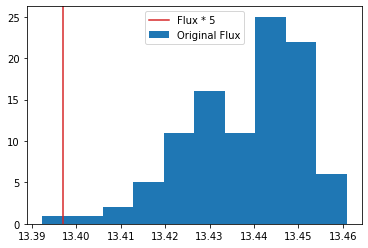

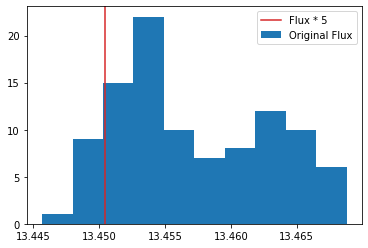

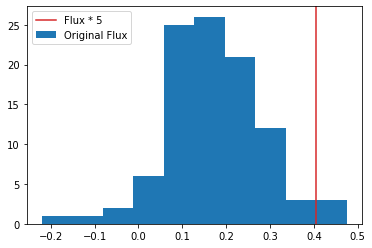

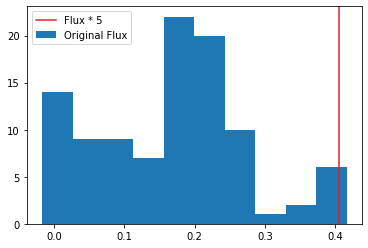

In [55]:
j=1
for i in range(11):
        plt.hist(posteriors_dist_or[j,:,i],color='tab:blue',label='Original Flux')
        plt.axvline(means5[j,i],0,1,color='tab:red',label='Flux * 5')
        plt.legend()
        plt.show()